In [1]:
import numpy as np

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from app.package.services import PyOctaveBand

In [2]:
from numpy import sqrt, newaxis
from numpy.fft import irfft, rfftfreq
from numpy.random import normal
from numpy import sum as npsum

def powerlaw_psd_gaussian(exponent, size, fmin=0):
    """Gaussian (1/f)**beta noise.
    Based on the algorithm in:
    Timmer, J. and Koenig, M.:
    On generating power law noise.
    Astron. Astrophys. 300, 707-710 (1995)
    Normalised to unit variance
    Parameters:
    -----------
    exponent : float
        The power-spectrum of the generated noise is proportional to
        S(f) = (1 / f)**beta
        flicker / pink noise:   exponent beta = 1
        brown noise:            exponent beta = 2
        Furthermore, the autocorrelation decays proportional to lag**-gamma
        with gamma = 1 - beta for 0 < beta < 1.
        There may be finite-size issues for beta close to one.
    shape : int or iterable
        The output has the given shape, and the desired power spectrum in
        the last coordinate. That is, the last dimension is taken as time,
        and all other components are independent.
    fmin : float, optional
        Low-frequency cutoff.
        Default: 0 corresponds to original paper. It is not actually
        zero, but 1/samples.
    Returns
    -------
    out : array
        The samples.
    Examples:
    ---------
    # generate 1/f noise == pink noise == flicker noise
    >>> import colorednoise as cn
    >>> y = cn.powerlaw_psd_gaussian(1, 5)
    """
    
    # Make sure size is a list so we can iterate it and assign to it.
    try:
        size = list(size)
    except TypeError:
        size = [size]
    
    # The number of samples in each time series
    samples = size[-1]
    
    # Calculate Frequencies (we asume a sample rate of one)
    # Use fft functions for real output (-> hermitian spectrum)
    f = rfftfreq(samples)
    
    # Build scaling factors for all frequencies
    s_scale = f
    fmin = max(fmin, 1./samples) # Low frequency cutoff
    ix   = npsum(s_scale < fmin)   # Index of the cutoff
    if ix and ix < len(s_scale):
        s_scale[:ix] = s_scale[ix]
    s_scale = s_scale**(-exponent/2.)
    
    # Calculate theoretical output standard deviation from scaling
    w      = s_scale[1:].copy()
    w[-1] *= (1 + (samples % 2)) / 2. # correct f = +-0.5
    sigma = 2 * sqrt(npsum(w**2)) / samples
    
    # Adjust size to generate one Fourier component per frequency
    size[-1] = len(f)

    # Add empty dimension(s) to broadcast s_scale along last
    # dimension of generated random power + phase (below)
    dims_to_add = len(size) - 1
    s_scale     = s_scale[(newaxis,) * dims_to_add + (Ellipsis,)]
    
    # Generate scaled random power + phase
    sr = normal(scale=s_scale, size=size)
    si = normal(scale=s_scale, size=size)
    
    # If the signal length is even, frequencies +/- 0.5 are equal
    # so the coefficient must be real.
    if not (samples % 2): si[...,-1] = 0
    
    # Regardless of signal length, the DC component must be real
    si[...,0] = 0
    
    # Combine power + corrected phase to Fourier components
    s  = sr + 1J * si
    
    # Transform to real time series & scale to unit variance
    y = irfft(s, n=samples, axis=-1) / sigma
    
    return y

In [3]:
len_audio = 2**15
num_channels = 2
fs = 44100

white_noise = np.random.rand(num_channels, len_audio)*2-1
# pink_noise = gen_pink_noise(num_channels, len_audio)*2-1
pink_noise_2 = powerlaw_psd_gaussian(1, [num_channels,len_audio])



In [4]:
scaling = np.max([np.max(pink_noise_2), abs(np.min(pink_noise_2))])
pink_noise_2 /= scaling


In [9]:
%%time 
spl_wn, freq = PyOctaveBand.octavefilter(white_noise, fs, fraction = 1)
spl_pn, freq = PyOctaveBand.octavefilter(pink_noise_2, fs, fraction = 1)

Wall time: 71.9 ms


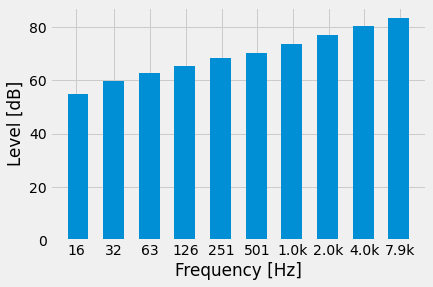

In [30]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

xtick = [int(f) for f in freq]
xticklabel = [str(round(f)) if f<1000 else str(round(f/1000, 1))+'k' for f in freq]

# Show octave spectrum
fig, ax = plt.subplots()
ax.bar(freq, spl_wn, width=np.array(freq)*2/5)
# ax.bar(freq, spl_pn, width=np.array(freq)*1)
ax.set_xscale('log')
ax.set_xlabel(r'Frequency [Hz]')
ax.set_ylabel('Level [dB]')
# plt.xlim(11, 25000)
ax.set_xticks(xtick)
ax.set_xticklabels(xticklabel)
plt.show()